# Project 3 - Predicting if a customer is going to default on his/her credit card

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import statsmodels.api as sm
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score,classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.feature_selection import RFE,RFECV,SelectKBest,chi2,f_classif
plt.style.use('seaborn-white')
%matplotlib inline


In [1]:
import sys
reload(sys)
sys.setdefaultencoding('utf8')


# Load the Data

In [284]:
default=pd.read_csv("././data/CreditDefault.csv")
default.head(5)

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,2,2.0,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2.0,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2.0,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2.0,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2.0,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [285]:
default.columns=['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE',
       'PAY_SEP', 'PAY_AUG', 'PAY_JUL', 'PAY_JUN', 'PAY_MAY', 'PAY_APR',
       'BILL_SEP', 'BILL_AUG', 'BILL_JUL', 'BILL_JUN', 'BILL_MAY',
       'BILL_APR', 'PAY_AMT_SEP', 'PAY_AMT_AUG', 'PAY_AMT_JUL', 'PAY_AMT_JUN',
       'PAY_AMT_MAY', 'PAY_AMT_APR', 'default']

#### EDA/Cleaning - Choose at least 4!
'''* Handling Missing Values (Required)
* `displot/histogram`
* `dtypes`
* `isnull` 
* `get_dummies`
* `map`
* `labelencoder`
'''

In [240]:
default.isnull().sum()

ID                0
LIMIT_BAL         0
SEX               0
EDUCATION      3036
MARRIAGE          0
AGE               0
PAY_SEP           0
PAY_AUG           0
PAY_JUL           0
PAY_JUN           0
PAY_MAY           0
PAY_APR           0
BILL_SEP          0
BILL_AUG       2543
BILL_JUL          0
BILL_JUN          0
BILL_MAY          0
BILL_APR          0
PAY_AMT_SEP       0
PAY_AMT_AUG       0
PAY_AMT_JUL       0
PAY_AMT_JUN       0
PAY_AMT_MAY       0
PAY_AMT_APR       0
default           0
dtype: int64

In [241]:
default.dtypes

ID               int64
LIMIT_BAL        int64
SEX              int64
EDUCATION      float64
MARRIAGE         int64
AGE              int64
PAY_SEP          int64
PAY_AUG          int64
PAY_JUL          int64
PAY_JUN          int64
PAY_MAY          int64
PAY_APR          int64
BILL_SEP         int64
BILL_AUG       float64
BILL_JUL         int64
BILL_JUN         int64
BILL_MAY         int64
BILL_APR         int64
PAY_AMT_SEP      int64
PAY_AMT_AUG      int64
PAY_AMT_JUL      int64
PAY_AMT_JUN      int64
PAY_AMT_MAY      int64
PAY_AMT_APR      int64
default          int64
dtype: object

Missing values: Education  -- coded as others
                BILL_AUG   -- looks like BILL_AUG is Null where there is no Bill Amount to pay
SEX - replaced with Dummy variable MALE 
MARRIAGE - recoded Marriage =0 to Marriage =3 Others , and replaced MARRIAGE with dummy variable SINGLE and MARRIED and dropped the Others
EDUCATION- recoded EDUCATION 0-3 as 0-3 and 4 for the other categories
PAY_XXX - recoded to reduce the dimensions in PAY_XXX to only contain -2 to 3, as only ~2% of the values were in 4-8 range.


In [286]:
#Map
# 2 Gender (1 = male; 2 = female).
#3 Education (1 = graduate school; 2 = university; 3 = high school; 4 = others).
#Marital status (1 = married; 2 = single; 3 = others)
#Drop ID column
default['MALE'] = default['SEX'].map( {1: 1, 2: 0})
default['SINGLE'] = default['MARRIAGE'].map( {0:0,1: 0, 2:1,3:0})
default['MARRIED'] = default['MARRIAGE'].map( {0:0,1: 1, 2: 0,3:0})
#default=default.drop('MARRIAGE',axis=1, inplace=True)
default.EDUCATION=default.EDUCATION.fillna(value=4.)
default.EDUCATION= [x if x <=4. else 4. for x in default.EDUCATION ]
default.PAY_SEP= [x if x <=3 else 3 for x in default.PAY_SEP ]
default.PAY_AUG= [x if x <=3 else 3 for x in default.PAY_SEP ]
default.PAY_JUL= [x if x <=3 else 3 for x in default.PAY_JUL ]
default.PAY_JUN= [x if x <=3 else 3 for x in default.PAY_JUN ]
default.PAY_MAY= [x if x <=3 else 3 for x in default.PAY_MAY ]
default.PAY_APR= [x if x <=3 else 3 for x in default.PAY_APR ] 
default.BILL_AUG=default.BILL_AUG.fillna(value=0) #Bill_AUG ==0 BILL_AUG==NAN

In [253]:
default['EDUCATION'].unique()

array([ 2.,  1.,  3.,  4.,  0.])

In [234]:
default['PAY_SEP'].value_counts()

 0    14737
-1     5686
 1     3688
-2     2759
 2     2667
 3      322
 4       76
 5       26
 8       19
 6       11
 7        9
Name: PAY_SEP, dtype: int64

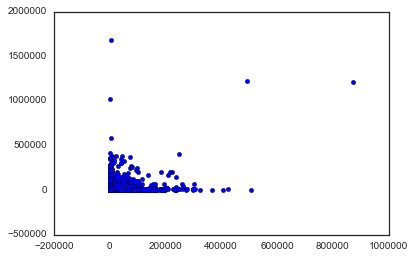

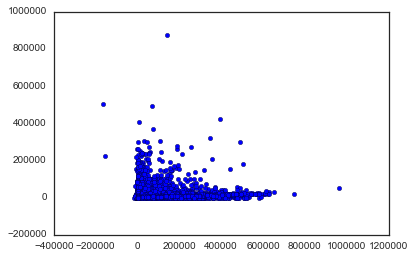

In [309]:
check_cor=default[['LIMIT_BAL','AGE',
       'BILL_SEP', 'BILL_AUG', 'BILL_JUL', 'BILL_JUN', 'BILL_MAY',
       'BILL_APR', 'PAY_AMT_SEP', 'PAY_AMT_AUG', 'PAY_AMT_JUL', 'PAY_AMT_JUN',
       'PAY_AMT_MAY', 'PAY_AMT_APR', 'default']]
plt.scatter(default['PAY_AMT_SEP'], default['PAY_AMT_AUG'])
plt.show()
plt.scatter(default['BILL_SEP'], default['PAY_AMT_SEP'])
plt.show()

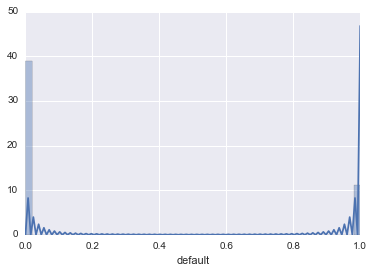

In [289]:
sns.distplot(default['default'])

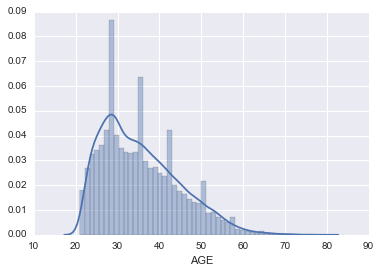

In [161]:
sns.distplot(default['AGE'])

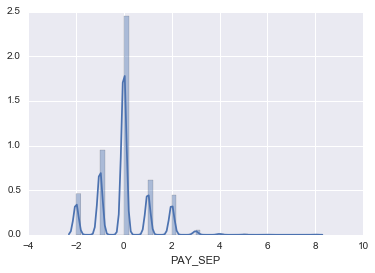

In [151]:
sns.distplot(default['PAY_SEP'])

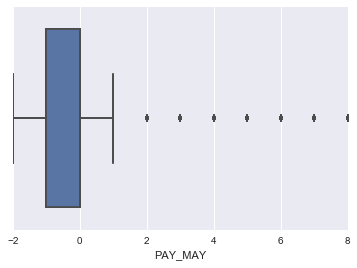

In [137]:
sns.boxplot(default.PAY_SEP)

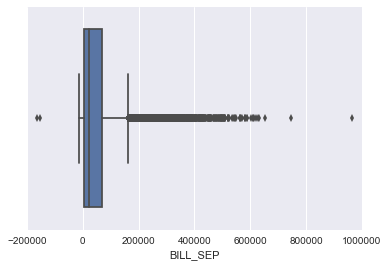

In [142]:
sns.boxplot(default.BILL_SEP)

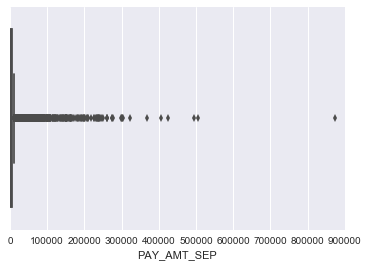

In [143]:
sns.boxplot(default.PAY_AMT_SEP)

# Model Prep - Choose at least 3!

* Train, Test Split (Required)
* Regularization
* Standardization
* Feature Scaling
* Feature Engineering (Making new features from existing features)

In [ ]:
* Train, Test Split (Required)
* Regularization
* Standardization


# Model - Choose at least 1!

* Linear Regression
* Logistic Regression
* KNN

In [313]:
#Base Model with no regularization and standardization bu train test
# Logistic Regression
X=default[default.columns-['default']-['ID']-['MARRIAGE']-['SEX']]
y= default.default


from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.cross_validation import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=77)

model = LogisticRegression()
model.fit(X_train,y_train)
print model.score(X_test,y_test)
y_pred = model.predict(X_test)

print classification_report(y_test, y_pred,target_names=["No Default", "Default"])


/Users/freh_mac/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: FutureWarning: using '-' to provide set differences with Indexes is deprecated, use .difference()
  app.launch_new_instance()


0.779292929293
             precision    recall  f1-score   support

 No Default       0.78      1.00      0.88      7716
    Default       0.00      0.00      0.00      2184

avg / total       0.61      0.78      0.68      9900



In [314]:
#Confusion Matrix:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
cm = pd.DataFrame(cm, columns=model.classes_, index=model.classes_)
cm

,0,1
0,7715,1
1,2184,0


In [304]:
# generic curve plotting function
def auc_plotting_function(rate1, rate2, rate1_name, rate2_name, curve_name):
    AUC = auc(rate1, rate2)
    # Plot of a ROC curve for class 1 (has_cancer)
    plt.figure(figsize=[11,9])
    plt.plot(rate1, rate2, label=curve_name + ' (area = %0.2f)' % AUC, linewidth=4)
    plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel(rate1_name, fontsize=18)
    plt.ylabel(rate2_name, fontsize=18)
    plt.title(curve_name + 'Customer Default on Credit Card Payment', fontsize=18)
    plt.legend(loc="lower right")
    plt.show()

# plot receiving operator characteristic curve
def plot_roc(y_true, y_score):
    fpr, tpr, _ = roc_curve(y_true, y_score)
    auc_plotting_function(fpr, tpr, 'False Positive Rate', 'True Positive Rate', 'ROC')


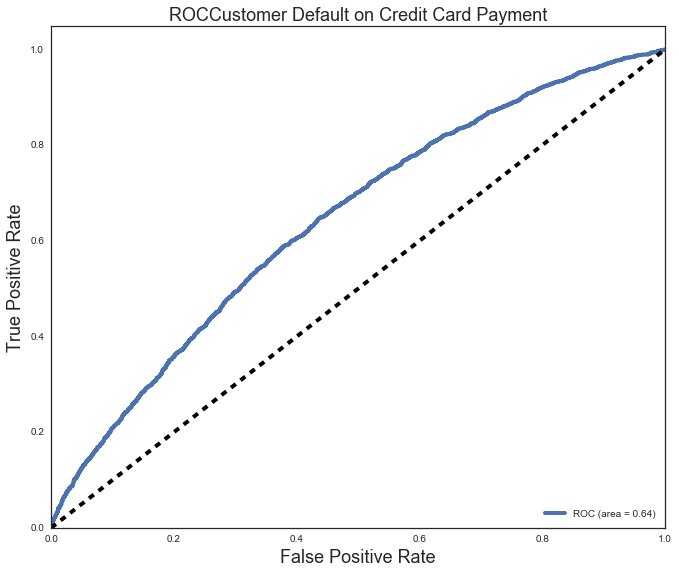

In [305]:
Y_score = model.decision_function(X_test)
plot_roc(y_test, Y_score)

In [ ]:
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, RobustScaler
#http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.RobustScaler.html#sklearn.preprocessing.RobustScaler
#standard_scaler = StandardScaler()

#X_train_std = standard_scaler.fit_transform(X_train)
#X_test_std = standard_scaler.transform(X_test)
#X_std=standard_scaler.transform(X)

robust_scaler = RobustScaler()
#X_train_r = robust_scaler.fit_transform(X_train)
#X_test_r = robust_scaler.fit_transform(X_test)
X_r=robust_scaler.fit_transform(X)

# Optimization - Choose at least 2!

* GridSearch
* One Recursive Feature Selection Method (the pay features are correlated to previous period Pay)

In [327]:
#Grid search for the best parameters
search_parameters = {}
from sklearn.grid_search import GridSearchCV

C_vals = [0.0001, 0.001, 0.01, 0.1, .15, .25, .275, .33, 0.5, .66, 0.75, 1.0, 2.5, 5.0, 10.0, 100.0, 1000.0]
penalties = ['l1','l2']
gridsearch = GridSearchCV(model, {'penalty': penalties, 'C': C_vals}, verbose=True, cv=10)
gridsearch.fit(X_r, y)

Fitting 10 folds for each of 34 candidates, totalling 340 fits


[Parallel(n_jobs=1)]: Done  49 tasks       | elapsed:    6.1s
[Parallel(n_jobs=1)]: Done 199 tasks       | elapsed:  1.2min
[Parallel(n_jobs=1)]: Done 340 out of 340 | elapsed:  2.4min finished


GridSearchCV(cv=10, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'penalty': ['l1', 'l2'], 'C': [0.0001, 0.001, 0.01, 0.1, 0.15, 0.25, 0.275, 0.33, 0.5, 0.66, 0.75, 1.0, 2.5, 5.0, 10.0, 100.0, 1000.0]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=True)

In [328]:
gridsearch.best_params_

{'C': 0.001, 'penalty': 'l2'}

# Best Fit

In [349]:
best_model = LogisticRegression(C= 0.001, penalty='l2')
best_model.fit(X_r,y)
print best_model.score(X_r,y)
y_pred = best_model.predict(X_r)


0.809933333333


# Results - Choose at least 3!

* Classification Report
* Confusion Matrix
* Accuracy Score 
* ROC/AUC 
* Presicion/Recall 
* `Cross_Val_Score`
* Error

In [350]:
print classification_report(y, y_pred,target_names=["No Default", "Default"])

             precision    recall  f1-score   support

 No Default       0.82      0.96      0.89     23364
    Default       0.68      0.27      0.38      6636

avg / total       0.79      0.81      0.78     30000



In [351]:
#Confusion Matrix:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y, y_pred, labels=model.classes_)
cm = pd.DataFrame(cm, columns=model.classes_, index=model.classes_)
cm

,0,1
0,22530,834
1,4868,1768


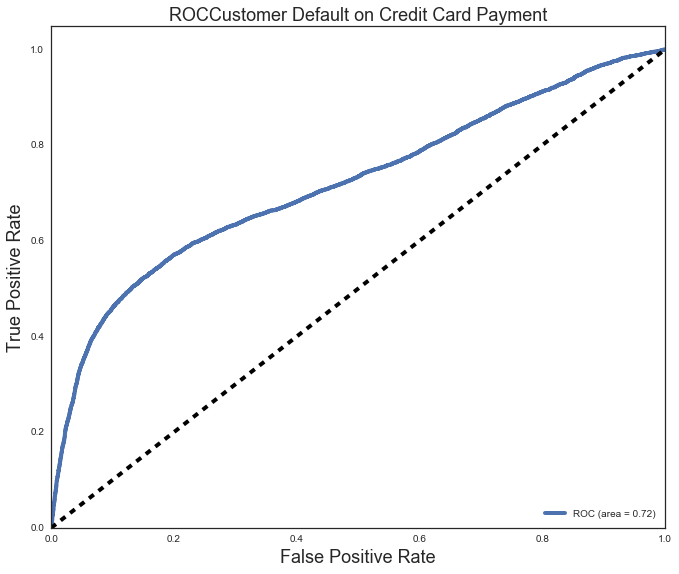

In [352]:
Y_score = best_model.decision_function(X_r)
plot_roc(y, Y_score)

# CONCLUSION

In [362]:
#Base model 
print len(X.columns) , 'features'
print X.columns

24 features
Index([u'AGE', u'BILL_APR', u'BILL_AUG', u'BILL_JUL', u'BILL_JUN', u'BILL_MAY',
       u'BILL_SEP', u'EDUCATION', u'LIMIT_BAL', u'MALE', u'MARRIED',
       u'PAY_AMT_APR', u'PAY_AMT_AUG', u'PAY_AMT_JUL', u'PAY_AMT_JUN',
       u'PAY_AMT_MAY', u'PAY_AMT_SEP', u'PAY_APR', u'PAY_AUG', u'PAY_JUL',
       u'PAY_JUN', u'PAY_MAY', u'PAY_SEP', u'SINGLE'],
      dtype='object')


In [353]:
print best_model.coef_

[[ 0.09145818  0.00453737 -0.03739289 -0.01303372 -0.0048993   0.01280559
  -0.09805431  0.09844671 -0.02561782 -0.10510818 -0.06496954 -0.01513542
  -0.04810013 -0.02239507 -0.02472237 -0.0198221  -0.06069134  0.05640411
   0.25194558  0.11513567  0.06504884  0.06372553  0.25194558  0.08513468]]


In [ ]:
#the highest coeffecients were PAY_AUG and PAY_SEP with coefficients 0.25194558 and 0.25194558

In [ ]:
#Method2--Recursive Feature Selection

In [369]:
logreg = LogisticRegression()

# Fit the features to the response variable
selector=RFECV(estimator=logreg,cv=5, step=.4,scoring='roc_auc',verbose=5) 
selected_data = selector.fit_transform(X_r,y)
rfecv_columns = X.columns[selector.get_support()]
Xtbest=pd.DataFrame(selected_data, columns=rfecv_columns)


Fitting estimator with 24 features.
Fitting estimator with 15 features.
Fitting estimator with 6 features.
Fitting estimator with 24 features.
Fitting estimator with 15 features.
Fitting estimator with 6 features.
Fitting estimator with 24 features.
Fitting estimator with 15 features.
Fitting estimator with 6 features.
Fitting estimator with 24 features.
Fitting estimator with 15 features.
Fitting estimator with 6 features.
Fitting estimator with 24 features.
Fitting estimator with 15 features.
Fitting estimator with 6 features.


In [371]:
print Xtbest.head(5)
print selector.support_

   PAY_AUG  PAY_SEP
0      2.0      2.0
1     -1.0     -1.0
2      0.0      0.0
3      0.0      0.0
4     -1.0     -1.0
[False False False False False False False False False False False False
 False False False False False False  True False False False  True False]


# The Goal of the project is to predict if a customer is going to default on their Credit Card loans and to find the best predictors from the data the customer has

the RFE and the best parameter logistic regression both selected the same 2 features as the top 2 that corelates with the default variable.
#The ROC_score is maximum around 0.2 

Summary from the model is  the probability of defaulting on Loan increases and dependent on previous two months defaulting history.